In [69]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [70]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [72]:
DATA_PATH = "/content/gdrive/MyDrive/WAR misinformation/Final Dataset/Final Data/final_data_acl.csv" 

In [73]:
pandas_df = pd.read_csv(DATA_PATH)
pandas_df.head()

,TweetID,TweetText,Labels,Targets
0,1498812104148721668,"Are you a conservative who praised Putin, but ...",1,1.0
1,1498812116836360194,🇺🇦Ukrainian WEF Nazis bombing their own people...,1,3.0
2,1498812179440717825,"""Putin pays Trump."" \nKevin McCarthy \nJune 15...",1,1.0
3,1498812208922259458,🇺🇦 Go Fuck Yourself Russia!! 🇺🇦 https://t.co/b...,1,3.0
4,1498812217747292163,Russia better get ready... The Media has decid...,1,1.0


In [74]:
for i in range(pandas_df.shape[0]):
  if(pandas_df['Targets'][i]==3):
    pandas_df['Targets'][i]=0

<ipython-input-74-0034a724ffd8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['Targets'][i]=0


In [75]:
pandas_df = pandas_df[pandas_df['Targets'].notna()]

In [76]:
pandas_df['Targets'] = pd.to_numeric(pandas_df['Targets'],downcast='integer')

<ipython-input-76-4f53dd4e3088>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['Targets'] = pd.to_numeric(pandas_df['Targets'],downcast='integer')


In [77]:
pandas_df

,TweetID,TweetText,Labels,Targets
0,1498812104148721668,"Are you a conservative who praised Putin, but ...",1,1
1,1498812116836360194,🇺🇦Ukrainian WEF Nazis bombing their own people...,1,0
2,1498812179440717825,"""Putin pays Trump."" \nKevin McCarthy \nJune 15...",1,1
3,1498812208922259458,🇺🇦 Go Fuck Yourself Russia!! 🇺🇦 https://t.co/b...,1,0
4,1498812217747292163,Russia better get ready... The Media has decid...,1,1
...,...,...,...,...
4217,1496014133216620544,22222 Ukraines Zelensky says not afraid aft...,1,0
4218,1496006077623713796,2 ex soviet super solider assassins and their ...,1,2
4219,1496033851898044424,10DowningStreet Putin will be running scared,1,1
4220,1496004936383045634,1 dumbass 2 dumbasses \n dombass Ukraine Putin...,1,1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


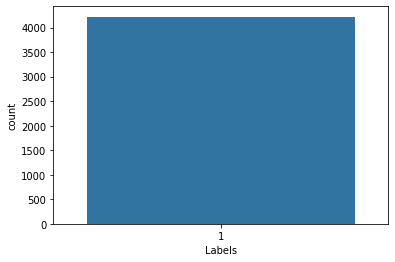

In [78]:
import seaborn as sns
sns.countplot('Labels', data=pandas_df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


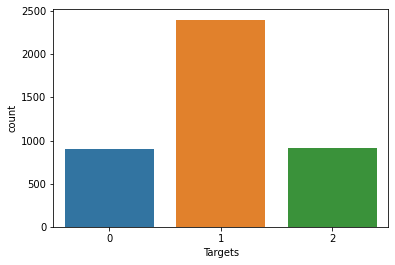

In [79]:
sns.countplot('Targets', data=pandas_df)

In [80]:
import re
Tweet = []
for tweettext in pandas_df["TweetText"]:
  text = re.sub(r"http\S+", "", tweettext)
  text = re.sub(r"@\S+","",text)
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'',text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text)
  #print(text)
  Tweet.append(text)

In [81]:
pandas_df['tweet_cleaned'] = pd.Series(Tweet)
pandas_df.head()

,TweetID,TweetText,Labels,Targets,tweet_cleaned
0,1498812104148721668,"Are you a conservative who praised Putin, but ...",1,1,Are you a conservative who praised Putin but n...
1,1498812116836360194,🇺🇦Ukrainian WEF Nazis bombing their own people...,1,0,Ukrainian WEF Nazis bombing their own people
2,1498812179440717825,"""Putin pays Trump."" \nKevin McCarthy \nJune 15...",1,1,Putin pays Trump Kevin McCarthy June 15th 2016
3,1498812208922259458,🇺🇦 Go Fuck Yourself Russia!! 🇺🇦 https://t.co/b...,1,0,Go Fuck Yourself Russia
4,1498812217747292163,Russia better get ready... The Media has decid...,1,1,Russia better get ready The Media has decided


In [82]:
words_len = []
for i in range(len(pandas_df['tweet_cleaned'])):
  s = pandas_df['tweet_cleaned'][i].split() 
  words_len.append(len(s))

In [83]:
largest_sen = max(wordlen for wordlen in words_len)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 24 words


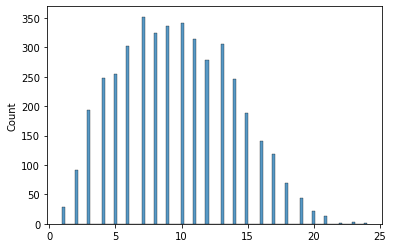

In [84]:
sns.histplot(data= [w for w in words_len],bins=100)

In [85]:
largest_sen = max(len(tweettext) for tweettext in Tweet)
print('biggest sentence has {} characters'.format(largest_sen))

biggest sentence has 115 characters


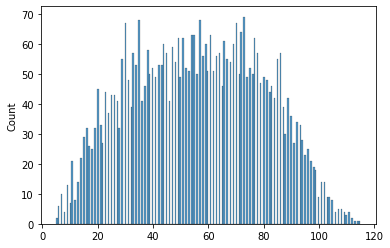

In [86]:
sns.histplot([len(s) for s in Tweet], bins = 200)

In [87]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['TweetID', 'TweetText', 'Labels', 'Targets', 'tweet_cleaned', '__index_level_0__'],
    num_rows: 4222
})

In [88]:
dataset = load_dataset('csv', data_files=DATA_PATH, split='train')

dataset

Dataset({
    features: ['TweetID', 'TweetText', 'Labels', 'Targets'],
    num_rows: 20765
})

In [89]:
train_test_valid = ds.train_test_split(test_size=0.3,shuffle=True)

test_valid = train_test_valid['test'].train_test_split(test_size=0.5,shuffle=True)

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['TweetID', 'Labels','__index_level_0__'])
dataset

DatasetDict({
    train: Dataset({
        features: ['TweetText', 'Targets', 'tweet_cleaned'],
        num_rows: 2955
    })
    test: Dataset({
        features: ['TweetText', 'Targets', 'tweet_cleaned'],
        num_rows: 634
    })
    valid: Dataset({
        features: ['TweetText', 'Targets', 'tweet_cleaned'],
        num_rows: 633
    })
})

In [90]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [91]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 30522
Model max length is : 512
Model input names are: ['input_ids', 'attention_mask']


In [92]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True) 


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [93]:
train_dataset

Dataset({
    features: ['TweetText', 'Targets', 'tweet_cleaned', 'input_ids', 'attention_mask'],
    num_rows: 2955
})

In [94]:
train_set = train_dataset.remove_columns(['TweetText', 'tweet_cleaned']).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['TweetText', "tweet_cleaned"]).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['TweetText', "tweet_cleaned"]).with_format('tensorflow')

In [95]:
train_set

Dataset({
    features: ['Targets', 'input_ids', 'attention_mask'],
    num_rows: 2955
})

In [96]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['Targets'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(16)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["Targets"]))
val_set_for_final_model = val_set_for_final_model.batch(16)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["Targets"]))
test_set_for_final_model =test_set_for_final_model.batch(16)

In [97]:
train_set_for_final_model

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [98]:
pandas_df["tweet_cleaned"]

0       Are you a conservative who praised Putin but n...
1           Ukrainian WEF Nazis bombing their own people 
2         Putin pays Trump Kevin McCarthy June 15th 2016 
3                                Go Fuck Yourself Russia 
4          Russia better get ready The Media has decided 
                              ...                        
4217    22222 Ukraine s Zelensky says not afraid after...
4218    2 ex soviet super solider assassins and their ...
4219         10DowningStreet Putin will be running scared
4220    1 dumbass 2 dumbasses dombass Ukraine Putin Biden
4221                                      Putin is coming
Name: tweet_cleaned, Length: 4222, dtype: object

In [99]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.layers import add, LSTM, Embedding, Dense
callbacks = [PlotLossesKeras()]

In [101]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)
# model = TFAutoModelForSequenceClassification.from_pretrained("/mnt/e0ccdbdb-22c3-4d9b-9413-fd976a2e99ae/M1/Code_Org/HF_Models/bert-base-uncased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


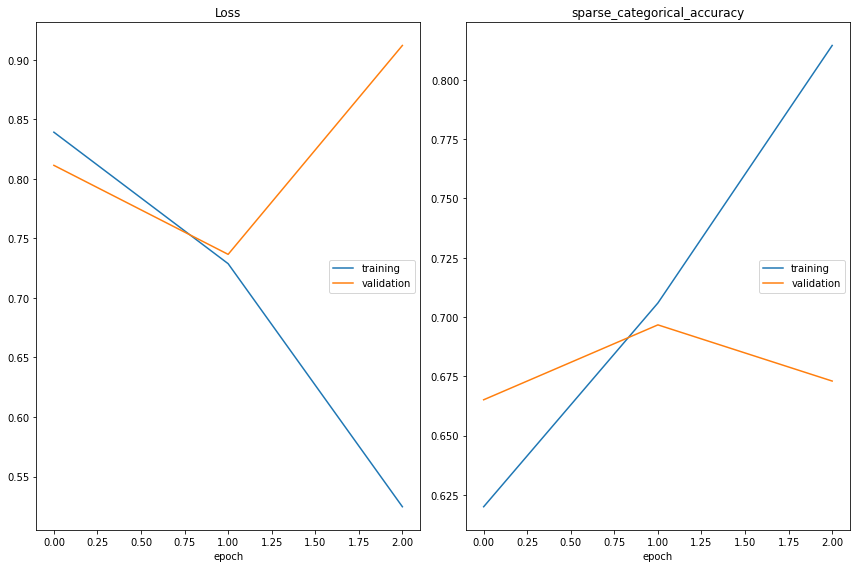

Loss
	training         	 (min:    0.525, max:    0.839, cur:    0.525)
	validation       	 (min:    0.737, max:    0.912, cur:    0.912)
sparse_categorical_accuracy
	training         	 (min:    0.620, max:    0.815, cur:    0.815)
	validation       	 (min:    0.665, max:    0.697, cur:    0.673)
185/185 [==============================] - 170s 917ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.9121 - val_sparse_categorical_accuracy: 0.6730


In [102]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3,callbacks=[callbacks],verbose=1 )

In [103]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=1)
print('\nTest accuracy:', test_acc)

40/40 [==============================] - 12s 297ms/step - loss: 0.8864 - sparse_categorical_accuracy: 0.6688

Test accuracy: 0.6687697172164917


In [104]:
preds = model.predict(test_set_for_final_model,verbose=1)

40/40 [==============================] - 13s 298ms/step


In [105]:
model.save('/content/gdrive/MyDrive/WAR misinformation/distilbert_targets')

In [106]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [108]:
len(preds['logits'])

634

In [128]:
test_labels = []
for i in range(len(test_valid['test']['Labels'])):
  l = test_valid['test']['Labels'][i]
  if(l==1):
    test_labels.append("INDIVIDUAL")
  elif(l==2):
    test_labels.append("ORGANISATION")
  else:
    test_labels.append("COMMUNITY")
  

In [127]:
np.array(test_valid['test']['Labels']).shape

(634,)

In [129]:
np.array(test_labels).shape

(634,)

In [130]:
preds_labels = []
for i in range(len(preds['logits'])):
  p = np.argmax(preds['logits'][i])
  if(p==1):
    preds_labels.append("INDIVIDUAL")
  elif(p==2):
    preds_labels.append("ORGANISATION")
  else:
    preds_labels.append("COMMUNITY")

In [ ]:
preds_labels

In [118]:
def extractDigits(lst):
    return [[el] for el in lst]

In [131]:
preds_labels = extractDigits(preds_labels)
test_labels = extractDigits(test_labels)

In [ ]:
test_labels

In [ ]:
preds_labels

In [132]:
np.array(preds_labels).shape

(634, 1)

In [133]:
np.array(test_labels).shape

(634, 1)

In [134]:
print(classification_report(preds_labels,test_labels))

              precision    recall  f1-score   support

   NDIVIDUAL       0.66      1.00      0.80       420
    OMMUNITY       0.00      0.00      0.00        43

   micro avg       0.66      0.91      0.77       463
   macro avg       0.33      0.50      0.40       463
weighted avg       0.60      0.91      0.72       463



/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: INDIVIDUAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORGANISATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COMMUNITY seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
print(f1_score(preds_labels, test_labels,average='micro'))

0.7657247037374659


In [136]:
print(precision_score(preds_labels, test_labels))

0.6624605678233438


In [ ]:
print(recall_score(preds_labels, test_labels))

0.8351309707241911
